In [1]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import torch
from PIL import Image
from diffusers import AutoPipelineForText2Image, StableDiffusionPipeline
from train_video import RateDistortionLoss
import requests
from transformers import AutoProcessor, LlavaForConditionalGeneration
import numpy as np
from utils import psnr,psnr_transform
from torchvision import transforms
import math
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from pytorch_msssim import ms_ssim

torch_device ='cuda'
generator = torch.Generator(device=torch_device )  # Place the generator on the CUDA device
generator.manual_seed(10)  

/data/maryam.sana/anaconda3/envs/compressai/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize to the input size expected by the model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

image = Image.open('data/custom_data/train/img00002.png')
print('size:', image.size) 

size: (1920, 1080)


In [3]:
model_path = "CompVis/stable-diffusion-v1-4"
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = StableDiffusionPipeline.from_pretrained(model_path, use_auth_token=True).to(device)

Keyword arguments {'use_auth_token': True} are not expected by StableDiffusionPipeline and will be ignored.
Loading pipeline components...: 100%|████████████████████████████| 7/7 [00:01<00:00,  5.85it/s]


In [4]:
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
img_latents = pipe.vae.encode(image_tensor.to('cuda'))
img_latents = img_latents.latent_dist.sample()
noise_std = 0.1  # This value can be adjusted based on your specific needs
noise = torch.randn_like(img_latents) * noise_std
img_latents = img_latents + noise
# img_latents = img_latents * pipe.scheduler.init_noise_sigma

100%|██████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.39it/s]


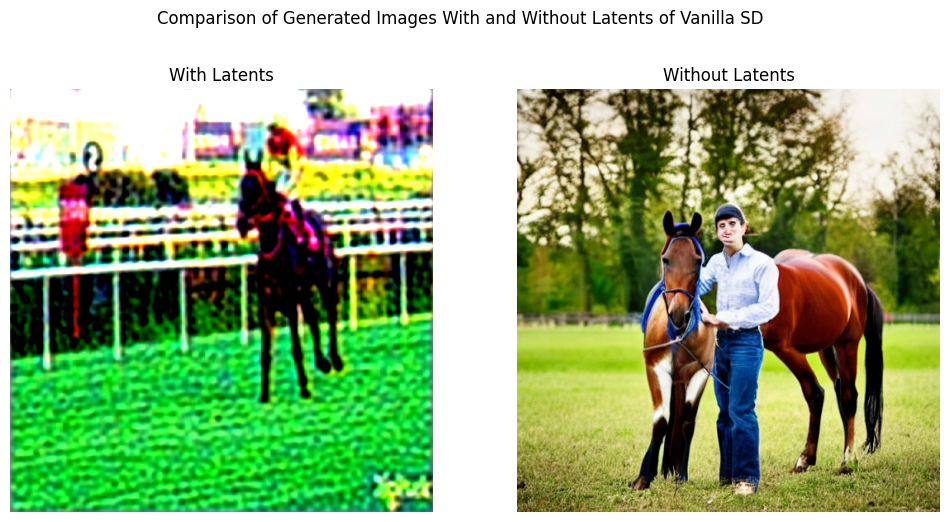

In [5]:
pred_with_latents = pipe(prompt="horse on grassy field with jockey", height=512, width=512,latents=img_latents).images[0]
pred = pipe(prompt="horse on grassy field with jockey", height=512, width=512).images[0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Display the image generated with latents on the first subplot
ax1.imshow(pred_with_latents)
ax1.set_title("With Latents")
ax1.axis('off')  # Turn off axis

# Display the image generated without latents on the second subplot
ax2.imshow(pred)
ax2.set_title("Without Latents")
ax2.axis('off')  # Turn off axis

# Add an overall title
plt.suptitle("Comparison of Generated Images With and Without Latents of Vanilla SD")

# Show the plot
plt.show()

In [6]:
# PSNR RESULTS 
orig_image= psnr_transform(image)

pred_l = psnr_transform(pred_with_latents).to('cpu').squeeze(0)
pred_wl = psnr_transform(pred).to('cpu').squeeze(0)

print('with latent: ',psnr(orig_image, pred_l,255).item())
print('without latent:', psnr(orig_image, pred_wl,255).item())


with latent:  12.294994354248047
without latent: 9.173900604248047


In [9]:
# ms_ssim_rgb = ms_ssim(orig_image, recons, data_range=255).item()
print('with latent: ',ms_ssim(orig_image.unsqueeze(0), pred_l.unsqueeze(0),255).item())
print('without latent:', ms_ssim(orig_image.unsqueeze(0), pred_wl.unsqueeze(0),255).item())

with latent:  0.5337515473365784
without latent: 0.021878337487578392


In [8]:
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_safetensors=True)
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="text_encoder", use_safetensors=True
)
unet = UNet2DConditionModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="unet", use_safetensors=True
)

In [9]:
from diffusers import UniPCMultistepScheduler

scheduler = UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

In [10]:
prompt = ["horse on grassy field with jockey"]
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 100  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
batch_size = len(prompt)
torch_device = "cuda"
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

In [11]:
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

In [12]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

In [13]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [14]:
random_latents = torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),
    generator=generator,
    device='cuda',
)
random_latents = random_latents * scheduler.init_noise_sigma
scheduler.set_timesteps(num_inference_steps)

In [15]:
def get_generated_images(latents):
    generated = []
    for i,t in enumerate(tqdm(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
    
        latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)
    
        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
    
        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    
        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample
    
        if i%10==0:
            latentsz = 1 / 0.18215 * latents
            with torch.no_grad():
                image = vae.decode(latentsz).sample
                img = image.to('cpu')
                print('psnr:', psnr(orig_image,img.squeeze(0)))
            
            image = (image / 2 + 0.5).clamp(0, 1).squeeze()
            image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
            image = Image.fromarray(image)      
            generated.append(image) 
            
    return generated,latents

In [16]:
scheduler.set_timesteps(100,'cuda')

In [17]:
image_tensor = transform(image).unsqueeze(0)
img_latents = vae.encode(image_tensor.to('cuda'))
img_latents = img_latents.latent_dist.sample()
noise_std = 3  # This value can be adjusted based on your specific needs
noise = torch.randn_like(img_latents) * noise_std
img_latents = img_latents + noise
img_latents = img_latents * scheduler.init_noise_sigma

# image_tensor = transform(image)
# noise = torch.randn_like(image_tensor) * 0.5
# noisy_image = image_tensor + noise
# noisy_image_clamped = noisy_image.clamp(0, 1).unsqueeze(0)
# noisy_image_clamped.shape
# img_latents = vae.encode(noisy_image_clamped.to('cuda'))
# img_latents = img_latents.latent_dist.sample()
# img_latents = img_latents * scheduler.init_noise_sigma

In [18]:
generated_images, lz = get_generated_images(img_latents)

  2%|█▌                                                                             | 2/100 [00:00<00:19,  5.13it/s]

psnr: tensor(47.9480)


 12%|█████████▎                                                                    | 12/100 [00:01<00:13,  6.54it/s]

psnr: tensor(47.4087)


 22%|█████████████████▏                                                            | 22/100 [00:03<00:11,  6.59it/s]

psnr: tensor(47.0770)


 32%|████████████████████████▉                                                     | 32/100 [00:04<00:10,  6.59it/s]

psnr: tensor(46.8880)


 42%|████████████████████████████████▊                                             | 42/100 [00:05<00:08,  6.57it/s]

psnr: tensor(46.7807)


 52%|████████████████████████████████████████▌                                     | 52/100 [00:07<00:07,  6.58it/s]

psnr: tensor(46.7187)


 62%|████████████████████████████████████████████████▎                             | 62/100 [00:08<00:05,  6.58it/s]

psnr: tensor(46.6810)


 72%|████████████████████████████████████████████████████████▏                     | 72/100 [00:10<00:04,  6.57it/s]

psnr: tensor(46.6580)


 82%|███████████████████████████████████████████████████████████████▉              | 82/100 [00:11<00:02,  6.56it/s]

psnr: tensor(46.6440)


 92%|███████████████████████████████████████████████████████████████████████▊      | 92/100 [00:12<00:01,  6.55it/s]

psnr: tensor(46.6358)


100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.18it/s]


In [19]:
# image_tensor = transform(image).unsqueeze(0)
# img_latents = vae.encode(image_tensor.to('cuda'))
# img_latents = img_latents.latent_dist.sample()
# img = pipe.vae.decode(img_latents,return_dict=False)[0].detach()
# pipe.image_processor.postprocess(img,output_type='pil')[0]

In [20]:

# noise_std = 4  # This value can be adjusted based on your specific needs
# noise = torch.randn_like(img_latents) * noise_std
# img_latents = img_latents + noise
# img_latents = img_latents * scheduler.init_noise_sigma

# img = pipe.vae.decode(img_latents,return_dict=False)[0].detach()
# pipe.image_processor.postprocess(img,output_type='pil')[0]

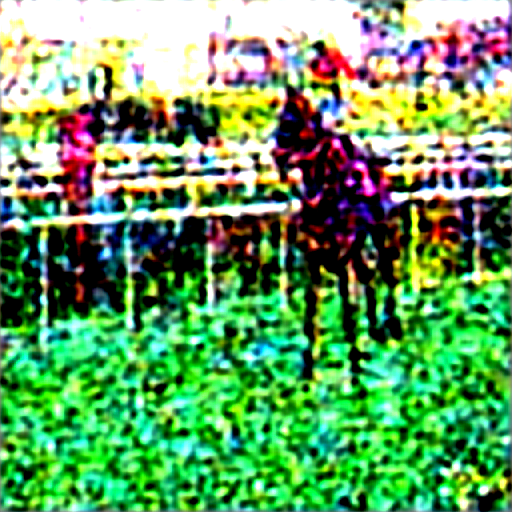

In [21]:
# scale and decode the image latents with vae
def get_decoded_images(latents):
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        recons_img = vae.decode(latents).sample  # Assuming 'sample' method is correct, might need '()' if it's a function call
    
    recons_img = (recons_img / 2 + 0.5).clamp(0, 1).squeeze()
    recons_img = (recons_img.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
    # psnr(orig_image, recons_img)
    recons_img = Image.fromarray(recons_img)
    return recons_img
    
get_decoded_images(lz)

In [22]:
recons_img = get_decoded_images(lz)
recons_img
reconst_tensor = transform2(recons_img).to('cpu')

print('psnr without latent:', psnr(orig_image,reconst_tensor.squeeze(0),255).item())


psnr without latent: 59.52194595336914


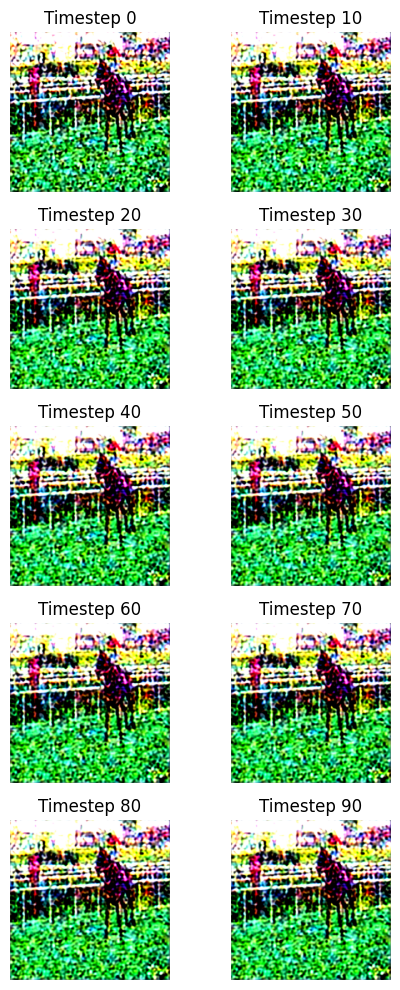

In [23]:
timesteps = [i * 10 for i in range(11)]

# Generate images for all specified timesteps
images = generated_images

# Create a figure with a 5x2 grid of axes
fig, axes = plt.subplots(5, 2, figsize=(5, 10))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Display each image in its respective subplot
for ax, img, t in zip(axes, images, timesteps):
    ax.imshow(img, cmap='gray')  # Assuming images are in grayscale for simplicity
    ax.set_title(f"Timestep {t}")
    ax.axis('off')  # Hide axes ticks

plt.tight_layout()
plt.show()

In [24]:
fig.savefig('result_vanila_sd_With_latent.png')